#Bert with BiLSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load hate speech data from CSV
data = pd.read_csv("/content/drive/MyDrive/Major Project Online Hate Speech - English/dataset/english.csv")

# Data Preprocessing
def clean_text(text):
    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters except spaces and letters
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

# Splitting the dataset into training and testing sets
X = data['clean_comment']
y = data['isHate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text data using BERT tokenizer
max_length = 128  # Adjust according to your dataset and computational resources
X_train_encoded = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

# Extract BERT embeddings for training and testing data
X_train_bert_output = bert_model(X_train_encoded)
X_test_bert_output = bert_model(X_test_encoded)

# Extract BERT embeddings (CLS token) as features
X_train_features = X_train_bert_output.last_hidden_state
X_test_features = X_test_bert_output.last_hidden_state

# Define BiLSTM model with multiple layers
input_layer = Input(shape=(max_length, 768))  # Assuming BERT-base embedding size is 768
bilstm_layer_1 = Bidirectional(LSTM(units=128, return_sequences=True))(input_layer)
dropout_layer_1 = Dropout(0.3)(bilstm_layer_1)
bilstm_layer_2 = Bidirectional(LSTM(units=64, return_sequences=True))(dropout_layer_1)
dropout_layer_2 = Dropout(0.3)(bilstm_layer_2)
bilstm_layer_3 = Bidirectional(LSTM(units=32, return_sequences=False))(dropout_layer_2)
dropout_layer_3 = Dropout(0.3)(bilstm_layer_3)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_3)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train BiLSTM model
history = model.fit(X_train_features, y_train, epochs=10, batch_size=16, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
40/40 [==============================] - 39s 730ms/step - loss: 0.6210 - accuracy: 0.6620 - val_loss: 0.4526 - val_accuracy: 0.7937
Epoch 2/10
40/40 [==============================] - 28s 705ms/step - loss: 0.5044 - accuracy: 0.7668 - val_loss: 0.3964 - val_accuracy: 0.8375
Epoch 3/10
40/40 [==============================] - 28s 707ms/step - loss: 0.4339 - accuracy: 0.8059 - val_loss: 0.3237 - val_accuracy: 0.8750
Epoch 4/10
40/40 [==============================] - 28s 699ms/step - loss: 0.3243 - accuracy: 0.8795 - val_loss: 0.3288 - val_accuracy: 0.8875
Epoch 5/10
40/40 [==============================] - 28s 696ms/step - loss: 0.2769 - accuracy: 0.8889 - val_loss: 0.3230 - val_accuracy: 0.8438
Epoch 6/10
40/40 [==============================] - 28s 705ms/step - loss: 0.2162 - accuracy: 0.9249 - val_loss: 0.2946 - val_accuracy: 0.9000
Epoch 7/10
40/40 [==============================] - 28s 695ms/step - loss: 0.1942 - accuracy: 0.9358 - val_loss: 0.3596 - val_accuracy: 0.8625

7/7 [==============================] - 2s 114ms/step - loss: 0.8799 - accuracy: 0.7300


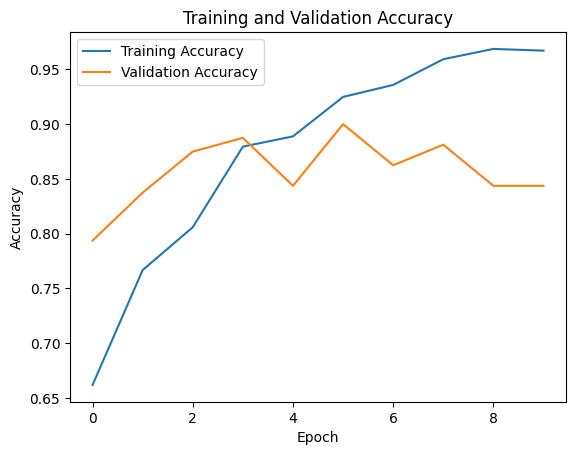

7/7 [==============================] - 2s 113ms/step
Training Accuracy: 0.9671361446380615
Validation Accuracy: 0.84375
Testing Accuracy: 0.7300000190734863
Precision: 0.6851851851851852
Recall: 0.7872340425531915
F1 Score: 0.7326732673267328


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Training and Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Testing Accuracy
test_accuracy = model.evaluate(X_test_features, y_test)[1]

# Loss vs Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Testing Metrics
y_pred = model.predict(X_test_features)
y_pred_binary = np.round(y_pred).astype(int)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [7]:
 # Save the trained model
model.save("bilstm_model")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          918528    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 128)          164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216 

In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("bilstm_model")

# Perform single prediction
text = "@JMC2488 @jetsgreen @TB12FAN and fuck you too ya little bitch you look like a Mexican sucking a cock in ur profile"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)
model.summary()

1/1 [==============================] - 2s 2s/step
Prediction: Hate
Accuracy: 0.9557604
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          918528    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 128)          164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                        

In [6]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("bilstm_model")

# Perform single prediction
text = "@X_XPDOTJDOT: Damn near gotta protect my tweets.. stalkers being annoying you got that dope dick. Drive these bitches loco"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)
model.summary()

1/1 [==============================] - 2s 2s/step
Prediction: Not Hate
Accuracy: 0.9342736229300499
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          918528    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 128)          164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                           

# Bert with CNN

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load hate speech data from CSV
data = pd.read_csv("final_dataset.csv")

# Data Preprocessing
def clean_text(text):
    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters except spaces and letters
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

# Splitting the dataset into training and testing sets
X = data['clean_comment']
y = data['isHate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text data using BERT tokenizer
max_length = 128  # Adjust according to your dataset and computational resources
X_train_encoded = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

# Extract BERT embeddings for training and testing data
X_train_bert_output = bert_model(X_train_encoded)
X_test_bert_output = bert_model(X_test_encoded)

# Extract BERT embeddings (CLS token) as features
X_train_features = X_train_bert_output.last_hidden_state
X_test_features = X_test_bert_output.last_hidden_state

# Reshape BERT embeddings for CNN
X_train_cnn = tf.reshape(X_train_features, (-1, max_length, 768))
X_test_cnn = tf.reshape(X_test_features, (-1, max_length, 768))

# Define CNN model with more convolutional layers
input_layer = Input(shape=(max_length, 768))  # Assuming BERT-base embedding size is 768
conv1d_layer_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
conv1d_layer_2 = Conv1D(filters=64, kernel_size=3, activation='relu')(conv1d_layer_1)
conv1d_layer_3 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1d_layer_2)
pooling_layer_1 = GlobalMaxPooling1D()(conv1d_layer_3)
dropout_layer_1 = Dropout(0.5)(pooling_layer_1)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN model
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=16, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Epoch 1/10
40/40 [==============================] - 2s 27ms/step - loss: 0.6791 - accuracy: 0.5681 - val_loss: 0.4934 - val_accuracy: 0.7750
Epoch 2/10
40/40 [==============================] - 1s 21ms/step - loss: 0.4996 - accuracy: 0.7559 - val_loss: 0.5159 - val_accuracy: 0.7312
Epoch 3/10
40/40 [==============================] - 1s 21ms/step - loss: 0.4427 - accuracy: 0.8075 - val_loss: 0.3206 - val_accuracy: 0.8750
Epoch 4/10
40/40 [==============================] - 1s 22ms/step - loss: 0.3510 - accuracy: 0.8670 - val_loss: 0.2722 - val_accuracy: 0.8938
Epoch 5/10
40/40 [==============================] - 1s 23ms/step - loss: 0.3353 - accuracy: 0.8607 - val_loss: 0.4266 - val_accuracy: 0.8250
Epoch 6/10
40/40 [==============================] - 1s 23ms/step - loss: 0.2556 - accuracy: 0.9030 - val_loss: 0.2725 - val_accuracy: 0.8938
Epoch 7/10
40/40 [==============================] - 1s 21ms/step - loss: 0.2220 - accuracy: 0.9171 - val_loss: 0.2651 - val_accuracy: 0.8813
Epoch 8/10
40

7/7 [==============================] - 0s 11ms/step - loss: 0.7209 - accuracy: 0.7800


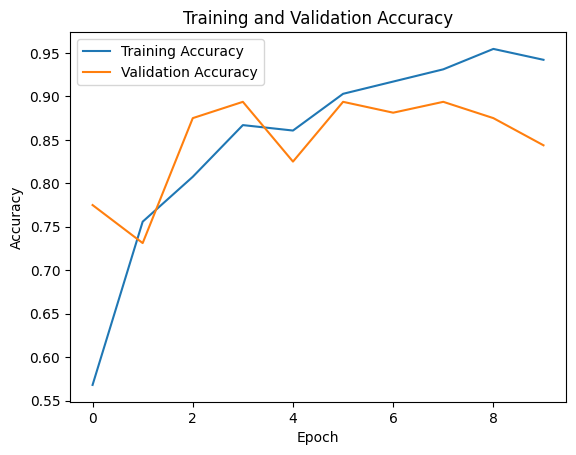

7/7 [==============================] - 0s 13ms/step
Training Accuracy: 0.942097008228302
Validation Accuracy: 0.84375
Testing Accuracy: 0.7799999713897705
Precision: 0.9166666666666666
Recall: 0.5851063829787234
F1 Score: 0.7142857142857143


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Training and Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Testing Accuracy
test_accuracy = model.evaluate(X_test_features, y_test)[1]

# Loss vs Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Testing Metrics
y_pred = model.predict(X_test_features)
y_pred_binary = np.round(y_pred).astype(int)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully 

In [ ]:
 # Save the trained model
model.save("cnn_model")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("cnn_model")

# Perform single prediction
text = "@JMC2488 @jetsgreen @TB12FAN and fuck you too ya little bitch you look like a Mexican sucking a cock in ur profile"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 188ms/step
Prediction: Hate
Accuracy: 0.9838252


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("cnn_model")

# Perform single prediction
text = "@X_XPDOTJDOT: Damn near gotta protect my tweets.. stalkers being annoying you got that dope dick. Drive these bitches loco"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 88ms/step
Prediction: Hate
Accuracy: 0.7135716


# Bert with RNN

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load hate speech data from CSV
data = pd.read_csv("final_dataset.csv")

# Data Preprocessing
def clean_text(text):
    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters except spaces and letters
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

# Splitting the dataset into training and testing sets
X = data['clean_comment']
y = data['isHate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text data using BERT tokenizer
max_length = 128  # Adjust according to your dataset and computational resources
X_train_encoded = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

# Extract BERT embeddings for training and testing data
X_train_bert_output = bert_model(X_train_encoded)
X_test_bert_output = bert_model(X_test_encoded)

# Extract BERT embeddings (CLS token) as features
X_train_features = X_train_bert_output.last_hidden_state
X_test_features = X_test_bert_output.last_hidden_state

# Reshape BERT embeddings for RNN
X_train_rnn = tf.reshape(X_train_features, (-1, max_length, 768))
X_test_rnn = tf.reshape(X_test_features, (-1, max_length, 768))

# Define RNN model with more recurrent layers
input_layer = Input(shape=(max_length, 768))  # Assuming BERT-base embedding size is 768
rnn_layer_1 = SimpleRNN(units=128, return_sequences=True)(input_layer)
rnn_layer_2 = SimpleRNN(units=64, return_sequences=True)(rnn_layer_1)
rnn_layer_3 = SimpleRNN(units=32)(rnn_layer_2)
dropout_layer = Dropout(0.5)(rnn_layer_3)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN model
history = model.fit(X_train_rnn, y_train, epochs=10, batch_size=16, validation_split=0.2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
40/40 [==============================] - 14s 241ms/step - loss: 0.7386 - accuracy: 0.5618 - val_loss: 0.5761 - val_accuracy: 0.7312
Epoch 2/10
40/40 [==============================] - 9s 237ms/step - loss: 0.6813 - accuracy: 0.6416 - val_loss: 0.5179 - val_accuracy: 0.7437
Epoch 3/10
40/40 [==============================] - 9s 229ms/step - loss: 0.5849 - accuracy: 0.7136 - val_loss: 0.4111 - val_accuracy: 0.8062
Epoch 4/10
40/40 [==============================] - 9s 226ms/step - loss: 0.5615 - accuracy: 0.7496 - val_loss: 0.3900 - val_accuracy: 0.8250
Epoch 5/10
40/40 [==============================] - 9s 230ms/step - loss: 0.5260 - accuracy: 0.7512 - val_loss: 0.3940 - val_accuracy: 0.8375
Epoch 6/10
40/40 [==============================] - 9s 232ms/step - loss: 0.4279 - accuracy: 0.8091 - val_loss: 0.6231 - val_accuracy: 0.7312
Epoch 7/10
40/40 [==============================] - 9s 228ms/step - loss: 0.4270 - accuracy: 0.8028 - val_loss: 0.3971 - val_accuracy: 0.8313
Epoch

7/7 [==============================] - 0s 35ms/step - loss: 0.6233 - accuracy: 0.7700


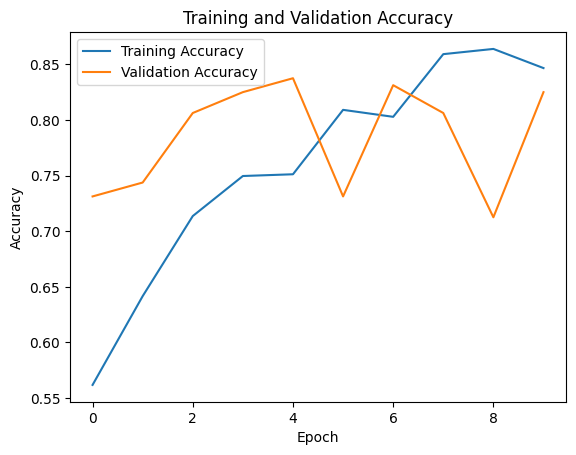

Training Accuracy: 0.8466353416442871
Validation Accuracy: 0.824999988079071
Testing Accuracy: 0.7699999809265137
Precision: 0.8157894736842105
Recall: 0.6595744680851063
F1 Score: 0.7294117647058823


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Training and Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Testing Accuracy
test_accuracy = model.evaluate(X_test_rnn, y_test)[1]

# Loss vs Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Flatten y_pred_binary to remove the extra dimension
y_pred_binary = y_pred_binary.flatten()

# Ensure both arrays have the same shape
assert y_test.shape == y_pred_binary.shape, "Shapes of y_test and y_pred_binary do not match"

# Calculate metrics using y_test and y_pred_binary
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
 # Save the trained model
model.save("rnn_model")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("rnn_model")

# Perform single prediction
text = "@JMC2488 @jetsgreen @TB12FAN and fuck you too ya little bitch you look like a Mexican sucking a cock in ur profile"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 316ms/step
Prediction: Hate
Accuracy: 0.8172884


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("rnn_model")

# Perform single prediction
text = "@X_XPDOTJDOT: Damn near gotta protect my tweets.. stalkers being annoying you got that dope dick. Drive these bitches loco"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 341ms/step
Prediction: Hate
Accuracy: 0.6687492


# Bert with ANN

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# Load hate speech data from CSV
data = pd.read_csv("final_dataset.csv")

# Data Preprocessing
def clean_text(text):
    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters except spaces and letters
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

# Splitting the dataset into training and testing sets
X = data['clean_comment']
y = data['isHate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text data using BERT tokenizer
max_length = 128  # Adjust according to your dataset and computational resources
X_train_encoded = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

# Extract BERT embeddings for training and testing data
X_train_bert_output = bert_model(X_train_encoded)
X_test_bert_output = bert_model(X_test_encoded)

# Extract BERT embeddings (CLS token) as features
X_train_features = X_train_bert_output.last_hidden_state.numpy()
X_test_features = X_test_bert_output.last_hidden_state.numpy()

# Define ANN model
input_layer = Input(shape=(max_length, 768))  # Assuming BERT-base embedding size is 768
flatten_layer = tf.keras.layers.Flatten()(input_layer)
dense_layer_1 = Dense(256, activation='relu')(flatten_layer)
dropout_layer_1 = Dropout(0.3)(dense_layer_1)
dense_layer_2 = Dense(128, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.3)(dense_layer_2)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train ANN model
history = model.fit(X_train_features, y_train, epochs=10, batch_size=16, validation_split=0.2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
40/40 [==============================] - 2s 14ms/step - loss: 3.9862 - accuracy: 0.5524 - val_loss: 0.9470 - val_accuracy: 0.7437
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 1.4944 - accuracy: 0.6823 - val_loss: 0.4934 - val_accuracy: 0.7875
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 0.6281 - accuracy: 0.7950 - val_loss: 0.5801 - val_accuracy: 0.7688
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 0.4779 - accuracy: 0.8310 - val_loss: 0.4468 - val_accuracy: 0.7437
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 0.3513 - accuracy: 0.8607 - val_loss: 0.4444 - val_accuracy: 0.7812
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2329 - accuracy: 0.8951 - val_loss: 0.4635 - val_accuracy: 0.7875
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2571 - accuracy: 0.9077 - val_loss: 0.6612 - val_accuracy: 0.7812
Epoch 8/10
40/40 [=

7/7 [==============================] - 0s 6ms/step - loss: 0.8863 - accuracy: 0.7150


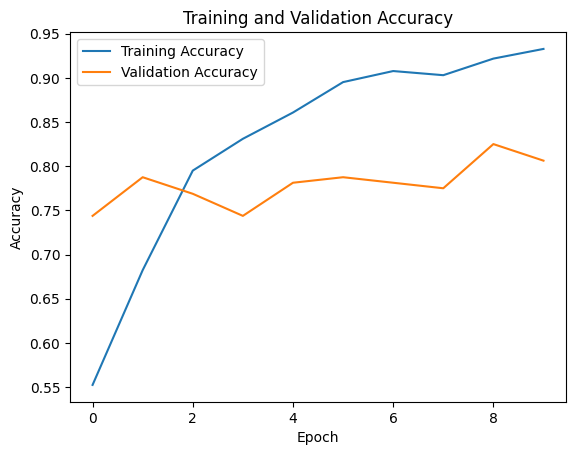

7/7 [==============================] - 0s 5ms/step
Training Accuracy: 0.9327073693275452
Validation Accuracy: 0.8062499761581421
Testing Accuracy: 0.7149999737739563
Precision: 0.6637168141592921
Recall: 0.7978723404255319
F1 Score: 0.7246376811594202


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Training and Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Testing Accuracy
test_accuracy = model.evaluate(X_test_features, y_test)[1]

# Loss vs Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Testing Metrics
y_pred = model.predict(X_test_features)
y_pred_binary = np.round(y_pred).astype(int)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
 # Save the trained model
model.save("ann_model")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("ann_model")

# Perform single prediction
text = "@JMC2488 @jetsgreen @TB12FAN and fuck you too ya little bitch you look like a Mexican sucking a cock in ur profile"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 60ms/step
Prediction: Hate
Accuracy: 0.9007051


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("ann_model")

# Perform single prediction
text = "@X_XPDOTJDOT: Damn near gotta protect my tweets.. stalkers being annoying you got that dope dick. Drive these bitches loco"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 59ms/step
Prediction: Hate
Accuracy: 0.72629607


In [ ]:
!pip install scikeras

# Bert With CNN & Esemble

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

# Load hate speech data from CSV
data = pd.read_csv("final_dataset.csv")

# Data Preprocessing
def clean_text(text):
    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters except spaces and letters
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

# Splitting the dataset into training and testing sets
X = data['clean_comment']
y = data['isHate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text data using BERT tokenizer
max_length = 128  # Adjust according to your dataset and computational resources
X_train_encoded = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

# Extract BERT embeddings for training and testing data
X_train_bert_output = bert_model(X_train_encoded)
X_test_bert_output = bert_model(X_test_encoded)

# Extract BERT embeddings (CLS token) as features
X_train_features = X_train_bert_output.last_hidden_state
X_test_features = X_test_bert_output.last_hidden_state

# Reshape BERT embeddings for CNN
X_train_cnn = tf.reshape(X_train_features, (-1, max_length, 768))
X_test_cnn = tf.reshape(X_test_features, (-1, max_length, 768))

def create_cnn_model():
    input_layer = Input(shape=(max_length, 768))  # Assuming BERT-base embedding size is 768
    conv1d_layer_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
    conv1d_layer_2 = Conv1D(filters=64, kernel_size=3, activation='relu')(conv1d_layer_1)
    conv1d_layer_3 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1d_layer_2)
    pooling_layer_1 = GlobalMaxPooling1D()(conv1d_layer_3)
    dropout_layer_1 = Dropout(0.5)(pooling_layer_1)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer_1)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_estimator = KerasClassifier(build_fn=create_cnn_model, epochs=10, batch_size=16, verbose=0)

# Train ensemble model
ensemble_model = VotingClassifier(estimators=[('cnn', cnn_estimator)], voting='hard')
ensemble_model.fit(X_train_cnn, y_train)

# Make predictions using ensemble model
ensemble_predictions = ensemble_model.predict(X_test_cnn)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Model Accuracy:", ensemble_accuracy)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Ensemble Model Accuracy: 0.78


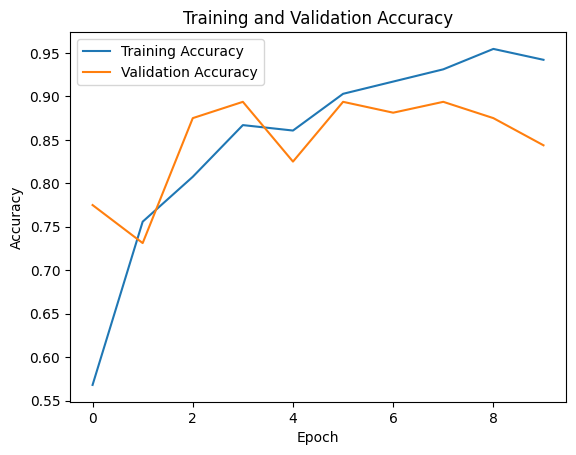

Training Accuracy: 0.942097008228302
Validation Accuracy: 0.84375
Testing Accuracy: 0.78
Precision: 0.8289473684210527
Recall: 0.6702127659574468
F1 Score: 0.7411764705882352


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Training and Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Testing Accuracy
test_accuracy = accuracy_score(y_test, ensemble_model.predict(X_test_cnn))

# Loss vs Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Testing Metrics
y_pred_ensemble = ensemble_model.predict(X_test_cnn)
y_pred_binary_ensemble = (y_pred_ensemble > 0.5).astype(int)
precision_ensemble = precision_score(y_test, y_pred_binary_ensemble)
recall_ensemble = recall_score(y_test, y_pred_binary_ensemble)
f1_ensemble = f1_score(y_test, y_pred_binary_ensemble)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision_ensemble)
print("Recall:", recall_ensemble)
print("F1 Score:", f1_ensemble)


# Bert with CNN & Activation

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Activation

# Load hate speech data from CSV
data = pd.read_csv("final_dataset.csv")

# Data Preprocessing
def clean_text(text):
    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters except spaces and letters
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

# Splitting the dataset into training and testing sets
X = data['clean_comment']
y = data['isHate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text data using BERT tokenizer
max_length = 128  # Adjust according to your dataset and computational resources
X_train_encoded = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

# Extract BERT embeddings for training and testing data
X_train_bert_output = bert_model(X_train_encoded)
X_test_bert_output = bert_model(X_test_encoded)

# Extract BERT embeddings (CLS token) as features
X_train_features = X_train_bert_output.last_hidden_state
X_test_features = X_test_bert_output.last_hidden_state

# Reshape BERT embeddings for CNN
X_train_cnn = tf.reshape(X_train_features, (-1, max_length, 768))
X_test_cnn = tf.reshape(X_test_features, (-1, max_length, 768))

# Define CNN model with more convolutional layers and different activation functions
input_layer = Input(shape=(max_length, 768))  # Assuming BERT-base embedding size is 768
conv1d_layer_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
conv1d_layer_2 = Conv1D(filters=64, kernel_size=3, activation='tanh')(conv1d_layer_1)
conv1d_layer_3 = Conv1D(filters=32, kernel_size=3, activation='sigmoid')(conv1d_layer_2)
pooling_layer_1 = GlobalMaxPooling1D()(conv1d_layer_3)
dropout_layer_1 = Dropout(0.5)(pooling_layer_1)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN model
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=16, validation_split=0.2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
40/40 [==============================] - 2s 24ms/step - loss: 0.7059 - accuracy: 0.5853 - val_loss: 0.5151 - val_accuracy: 0.8188
Epoch 2/10
40/40 [==============================] - 1s 20ms/step - loss: 0.5106 - accuracy: 0.7606 - val_loss: 0.3579 - val_accuracy: 0.8687
Epoch 3/10
40/40 [==============================] - 1s 20ms/step - loss: 0.3964 - accuracy: 0.8232 - val_loss: 0.3803 - val_accuracy: 0.8375
Epoch 4/10
40/40 [==============================] - 1s 21ms/step - loss: 0.3623 - accuracy: 0.8576 - val_loss: 0.3492 - val_accuracy: 0.8687
Epoch 5/10
40/40 [==============================] - 1s 21ms/step - loss: 0.2999 - accuracy: 0.8779 - val_loss: 0.2767 - val_accuracy: 0.9000
Epoch 6/10
40/40 [==============================] - 1s 22ms/step - loss: 0.2448 - accuracy: 0.9030 - val_loss: 0.3168 - val_accuracy: 0.8500
Epoch 7/10
40/40 [==============================] - 1s 21ms/step - loss: 0.2000 - accuracy: 0.9264 - val_loss: 0.2989 - val_accuracy: 0.8813
Epoch 8/10
40

7/7 [==============================] - 0s 13ms/step - loss: 0.5788 - accuracy: 0.8100


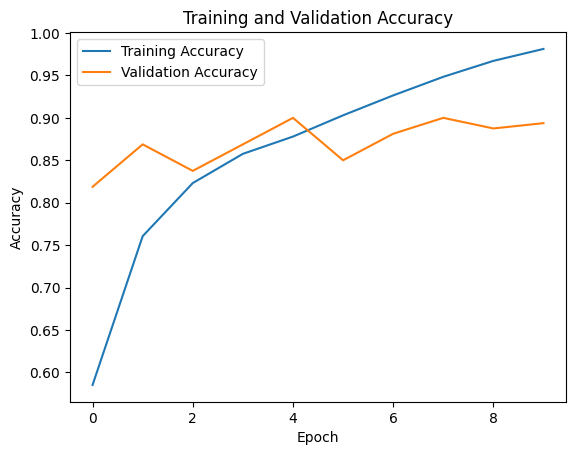

7/7 [==============================] - 0s 11ms/step
Training Accuracy: 0.9812206625938416
Validation Accuracy: 0.893750011920929
Testing Accuracy: 0.8100000023841858
Precision: 0.8333333333333334
Recall: 0.7446808510638298
F1 Score: 0.7865168539325842


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Training and Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Testing Accuracy
test_accuracy = model.evaluate(X_test_features, y_test)[1]

# Loss vs Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Testing Metrics
y_pred = model.predict(X_test_features)
y_pred_binary = np.round(y_pred).astype(int)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
# Perform single prediction
text = "@JMC2488 @jetsgreen @TB12FAN and fuck you too ya little bitch you look like a Mexican sucking a cock in ur profile"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 17ms/step
Prediction: Hate
Accuracy: 0.7863082


In [ ]:
# Perform single prediction
text = "@X_XPDOTJDOT: Damn near gotta protect my tweets.. stalkers being annoying you got that dope dick. Drive these bitches loco"
text_encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
bert_output = bert_model(text_encoded)
features = bert_output.last_hidden_state
features_reshaped = tf.reshape(features, (-1, max_length, 768))
predictions = model.predict(features_reshaped)

# Interpret the predictions
prediction_class = "Hate" if predictions[0][0] > 0.5 else "Not Hate"
accuracy = predictions[0][0] if prediction_class == "Hate" else 1 - predictions[0][0]
print("Prediction:", prediction_class)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 19ms/step
Prediction: Not Hate
Accuracy: 0.717127650976181
